# Example canary-gradient-based MIA

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from functools import partial

import models
from utility import lr_schlr
from canary_attack import load_dataset, setup_model, evaluate_canary_attack, inject_canary
from canary_utility import local_training

## Setup

In [2]:
rng_seed = 1
dataset_key = "cifar10"
dataset_key_shadow = "cifar100"
batch_size_train = 256
batch_size_test = 64

# attack
max_number_of_iters = 10000
opt = tf.keras.optimizers.Adam()

model_id = 'resnet20'
canary_id = 'last_layer'
loss_function = models.sparse_classification_loss
max_number_of_iters = 3000
loss_threshold = 0.001

max_num_batches_eval = 100

# FedAVG
num_iter_fedAVG = 15
learning_rate_fedAVG = 0.001

name = '_'.join(map(str,[dataset_key, dataset_key_shadow, batch_size_train, loss_threshold, model_id, canary_id, loss_threshold, learning_rate_fedAVG]))
print(name)

cifar10_cifar100_256_0.001_resnet20_last_layer_0.001_0.001


## Load datasets

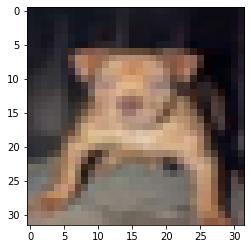

In [3]:
tf.random.set_seed(rng_seed)
np.random.seed(rng_seed)  

validation, shadow, x_shape, class_num, (x_target, y_target) = load_dataset(
    dataset_key,
    dataset_key_shadow,
    batch_size_test,
    batch_size_train,
    data_aug_shadow=False
)
    
plt.imshow((x_target[0]+1)/2);

## Chosing canary location (i.e., $\xi$)

In [4]:
model, layer_idx, g_canary_shift, kernel_idx, pre_canary_layer_trainable_variables = setup_model(model_id, canary_id, x_shape, class_num)

----> layer_normalization_20 (None, 8, 8, 64)
--------> (None, 8, 8)
input_1

conv2d
	 conv2d/kernel:0

layer_normalization
	 layer_normalization/gamma:0
	 layer_normalization/beta:0

activation

conv2d_1
	 conv2d_1/kernel:0

layer_normalization_1
	 layer_normalization_1/gamma:0
	 layer_normalization_1/beta:0

activation_1

conv2d_2
	 conv2d_2/kernel:0

layer_normalization_2
	 layer_normalization_2/gamma:0
	 layer_normalization_2/beta:0

activation_2

tf.__operators__.add

conv2d_3
	 conv2d_3/kernel:0

layer_normalization_3
	 layer_normalization_3/gamma:0
	 layer_normalization_3/beta:0

activation_3

conv2d_4
	 conv2d_4/kernel:0

layer_normalization_4
	 layer_normalization_4/gamma:0
	 layer_normalization_4/beta:0

activation_4

tf.__operators__.add_1

conv2d_5
	 conv2d_5/kernel:0

layer_normalization_5
	 layer_normalization_5/gamma:0
	 layer_normalization_5/beta:0

activation_5

conv2d_6
	 conv2d_6/kernel:0

layer_normalization_6
	 layer_normalization_6/gamma:0
	 layer_normalization_6/

## Injecting Canary

Loss Threshold reached!


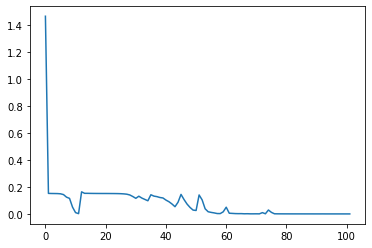

In [5]:
logs = inject_canary(
    max_number_of_iters,
    batch_size_train,
    model,
    x_target,
    shadow,
    pre_canary_layer_trainable_variables,
    opt,
    loss_threshold=loss_threshold
)

plt.plot(logs[0]);

## Evaluate FedSGD

In [6]:
test_canary_fn = partial(
    evaluate_canary_attack,
    target=x_target,
    variables=pre_canary_layer_trainable_variables,
    loss_function=loss_function,
    g_canary_shift=g_canary_shift,
    kernel_idx=kernel_idx,
    max_num_batches_eval=max_num_batches_eval
)
    

out, failed = test_canary_fn(model, validation)
out

Max number of iterations evaluation reached!


{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}

## Evaluate FedAVG (run local SGD step and test canary again)

In [7]:
canary_scores_FedAVG = local_training(
    model,
    validation,
    num_iter_fedAVG,
    learning_rate_fedAVG,
    loss_function,
    test_canary_fn
)

Max number of iterations evaluation reached!
 FedAVG round: 1
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 2
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 3
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 4
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 5
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 6
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 7
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 8
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 9
	{'accuracy': 1.0, 'recall